In [1]:
from pybaselines import Baseline, utils
import spectral
import pysptools
from spectral import *
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal, interpolate, stats
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, find_peaks_cwt
from scipy.optimize import curve_fit
import pandas as pd
import warnings

# Suppress pandas warnings
warnings.filterwarnings('ignore')

def get_mask_from_waves(wav_array, wav_min, wav_max):
   return (wav_array >= wav_min) * (wav_array <= wav_max)


def compute_EGO_Gaussian(lmbda, si, mu_i, sigma_i, k_i):
    # EGO Gaussian function
    return si * np.exp(-0.5 * ((lmbda - mu_i) ** 2 / (sigma_i - k_i * (lmbda - mu_i)) ** 2))

def extract_all_sheets(file_path):
    excel_file = pd.ExcelFile(file_path)
    sheet_names = excel_file.sheet_names
    
    all_data = [excel_file.parse(sheet_name, header = None) for sheet_name in sheet_names]
    
    return all_data

def get_spreadsheet_coords(df, label):
    """
    Accepets either a single label or a list
    """
    if type(label) is str:
        x_ind, y_ind = np.where(mineral_df == label)
        return x_ind[0], y_ind[0]

    elif type(label) is list:
        x_ind = []
        y_ind = []
        for list_val in label:
            x, y = np.where(mineral_df == list_val)
            x_ind.append(x[0])
            y_ind.append(y[0])
        return np.asarray(x_ind), np.asarray(y_ind)


def get_val_list(df,
                 val_name):
    # Identify how many features we have here
    start_x, start_y = get_spreadsheet_coords(df, val_name)
    val_list = []
    for i in range(start_x +1, df.shape[0]):
        curr_val = df.iloc[i , start_y]
        if i >= df.shape[0]:
            break
        elif not pd.isna(curr_val):
            val_list.append(curr_val)
        else:
            break
    
    print(f"Found {len(val_list)}: {val_list}")
    return val_list

Current data is shaped: (1250, 100, 514)


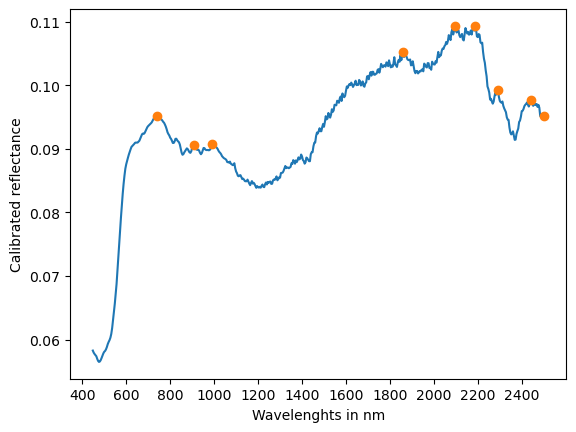

In [2]:
header = envi.read_envi_header('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr')
# img = open_image('spectra/JA0464_18423_0001_20190207135542_00.procProf3d.hdr')
                 # image = 'spectra/JA0464_18423_0001_20190207135542_00.procProf3d.bin')
curr_data = envi.open('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr', image = 'spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.bin')

curr_data_array = curr_data.asarray()
print(f"Current data is shaped: {curr_data_array.shape}")

# Let's get the wavelengths in a format we can use
wav_list = [val[0:-2] for val in header['band names']]
wav_array = np.asarray(wav_list).astype(float)

# and the units
wav_unit = header['wavelength units']
n_bands = header['bands']

# Set the pixel we want for now

curr_x = 50
curr_y = 54

curr_pixel = curr_data_array[curr_x, curr_y, :]
plt.plot(wav_array, curr_pixel)
plt.xlabel('Wavelenghts in ' + wav_unit)
plt.ylabel('Calibrated reflectance')
plt.xticks(np.arange(400,2500, step = 200))

# Get the peaks of the current spectrum
peaks = find_peaks(curr_pixel,
                   width = 5)[0]
# Append the end of the spectrum
peaks = np.append(peaks, curr_pixel.shape[0]-1)

plt.plot(wav_array[peaks], curr_pixel[peaks], 'o')

# Let's start by ingesting the criteria we've gotten from Cari
ref_lib_data = extract_all_sheets('Ref Library match criteria v1.xlsx')

Text(0, 0.5, 'Calibrated reflectance')

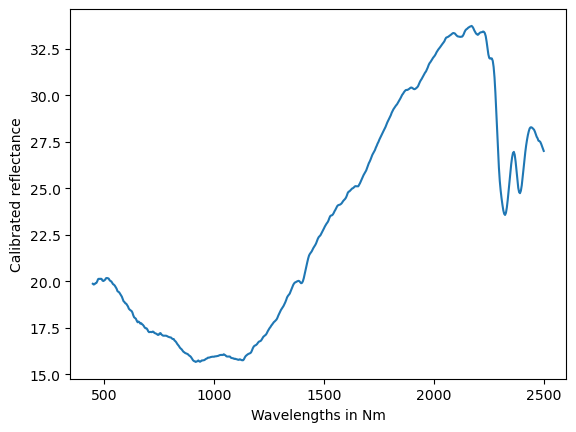

In [15]:
# Shoehorn in the loading of a standard reference spectrum instead 

ref_data = pd.read_csv('reference_lib/Amphibole_03.csv')
wav_array = ref_data.iloc[:,0].values
curr_pixel =  ref_data.iloc[:,1].values

# # Let's get the wavelengths in a format we can use
# wav_list = [val[0:-2] for val in header['band names']]
# wav_array = np.asarray(wav_list).astype(float)

# # and the units
# wav_unit = header['wavelength units']
# n_bands = header['bands']

# # Set the pixel we want for now

# curr_x = 50
# curr_y = 54

plt.plot(wav_array, curr_pixel)
plt.xlabel('Wavelengths in ' + 'Nm')
plt.ylabel('Calibrated reflectance')
# plt.xticks(np.arange(400,2500, step = 200))

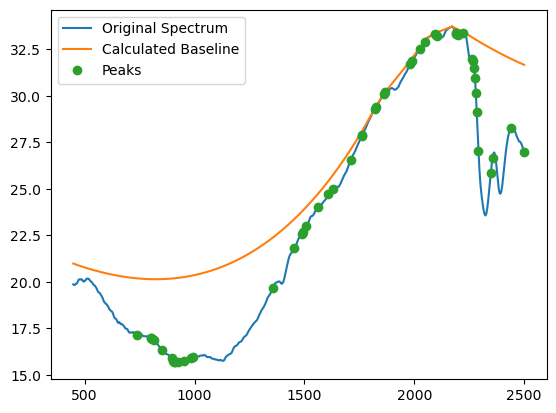

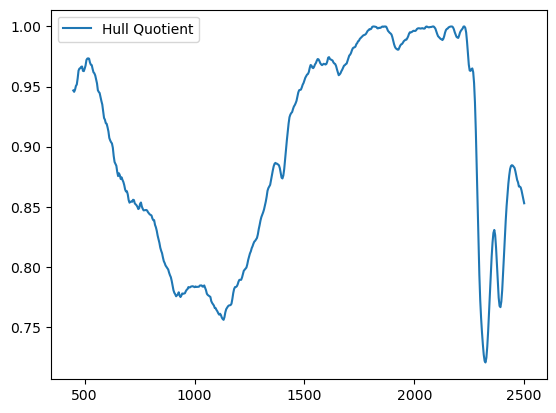

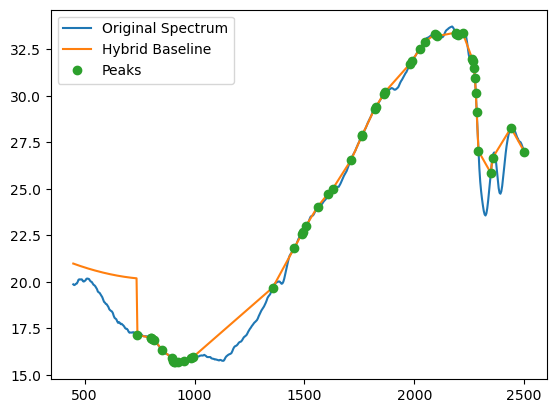

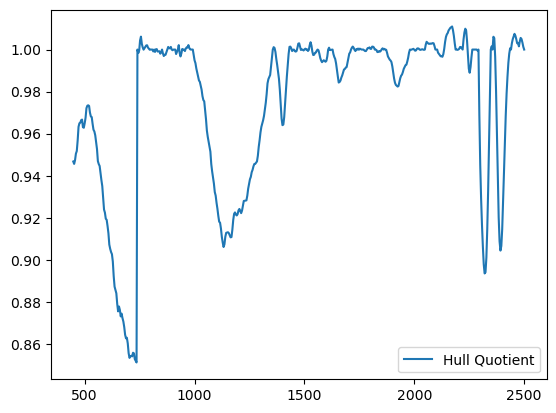

In [17]:
baseline_fitter = Baseline(wav_array,
                           check_finite=False)

# Invert the data 
pix_inverse = 1 / curr_pixel 

# Calculate the baseline
baseline_inv = baseline_fitter.snip(pix_inverse,
                             max_half_window=40,
                             decreasing=True,
                             smooth_half_window=0)[0]

# Invert the result
curr_baseline = 1 / baseline_inv         

plt.plot(wav_array, curr_pixel, label='Original Spectrum')
plt.plot(wav_array, curr_baseline, label='Calculated Baseline')
plt.plot(wav_array[peaks], curr_pixel[peaks], 'o', label='Peaks')
plt.legend()

plt.figure()
plt.plot(wav_array, curr_pixel/curr_baseline, label='Hull Quotient')
plt.legend()

# Interpolate linearly to get the lower hull
def interpolate_linear(spectrum, indices):
    # Create an interpolation function based on the given indices
    interp_func = interp1d(indices,
                           spectrum[indices],
                           fill_value="extrapolate")
    # Apply the interpolation function to the entire range of indices
    lower_hull = interp_func(np.arange(len(spectrum)))
    return lower_hull


prelim_hull = interpolate_linear(curr_pixel[peaks[0]:],
                                 peaks - peaks[0])

concat_hull = np.concatenate((curr_baseline[0:peaks[0]],
                              prelim_hull))
plt.figure()
plt.plot(wav_array, curr_pixel, label='Original Spectrum')
plt.plot(wav_array, concat_hull, label='Hybrid Baseline')
plt.plot(wav_array[peaks], curr_pixel[peaks], 'o', label='Peaks')
plt.legend()

curr_quotient = curr_pixel/concat_hull

plt.figure()
plt.plot(wav_array,
         curr_quotient,
         label='Hull Quotient')
plt.legend()

In [5]:
# Master peak ranges
# This data will need to be committed to a database table so that it can be extracted
# in a more easily edited central location
min_list = np.sort(np.asarray([820, 2490, 645, 790, 880, 1370, 1450, 1465, 1535, 1710, 1890, 1935, 2145, 2185, 2230, 2220, 2270, 2325, 2345, 2375]))
max_list = np.sort(np.asarray([980, 2550, 675, 810, 1150, 1420, 1490, 1500, 1565, 1785, 1940, 1960, 2185, 2230, 2265, 2300, 2330, 2370, 2390, 2415]))
mineral_label = ['iron oxides (goethite, hematite)', 'carbonates', 'molybdenite', 
                 'REE', 'pyroxene', 'micas, clays', 'jarosite', 'alunite', 
                 'epidote', 'sulphates', 'all OH, zeo', 'gypsum',
                 'pyrophyllite', 'Al-OH', 'chlorite, biotite', 'Al-fe smectites', 
                 'Fe-Mg smectites', 'chlorite, biotite', 'tourmaline', 'amphiboles, biotite']
hull_correct_bool = [False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


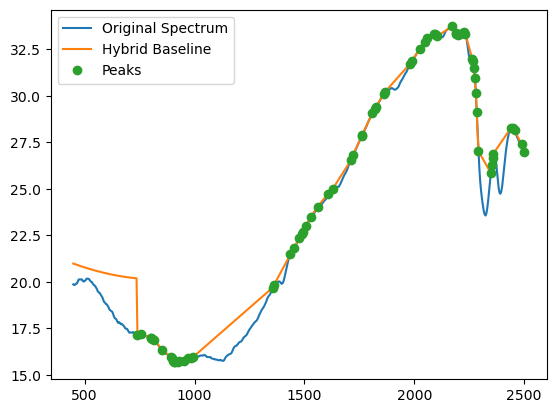

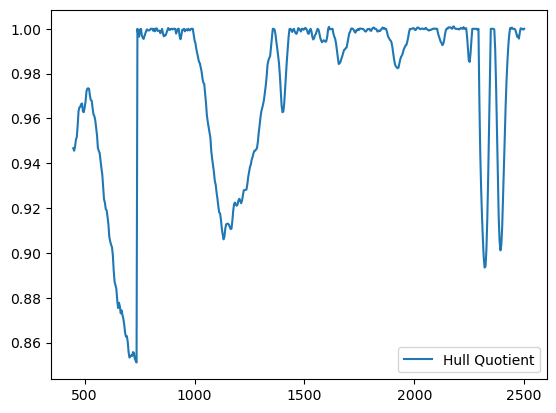

In [87]:
n_gt_one = (curr_quotient > 1.01).sum()
count = 0
while n_gt_one > 0:
    # plt.plot(curr_quotient)
    curr_index_to_add = curr_quotient.argmax()
    # Append this index to the peaks
    peaks = np.unique(np.sort(np.append(peaks, curr_index_to_add)))
    
    
    prelim_hull = interpolate_linear(curr_pixel[peaks[0]:],
                                     peaks - peaks[0])
    
    concat_hull = np.concatenate((curr_baseline[0:peaks[0]],
                                  prelim_hull))

    
    curr_quotient = curr_pixel/concat_hull
    n_gt_one = (curr_quotient > 1).sum()
    count +=1
    if count > 20:
        print('Too many iterations, breaking loop')
        n_gt_one = -1

plt.figure()
plt.plot(wav_array, curr_pixel, label='Original Spectrum')
plt.plot(wav_array, concat_hull, label='Hybrid Baseline')
plt.plot(wav_array[peaks], curr_pixel[peaks], 'o', label='Peaks')
plt.legend()

plt.figure()
plt.plot(wav_array,
         curr_quotient,
         label='Hull Quotient')
plt.legend()

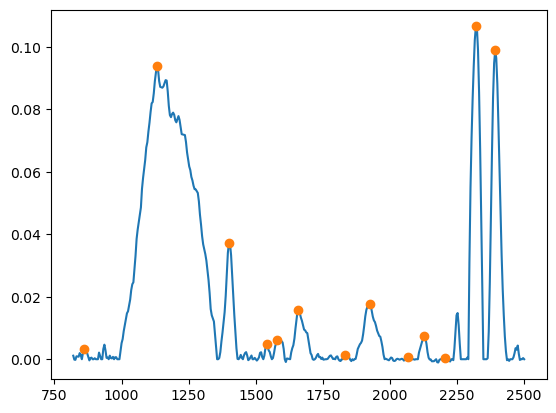

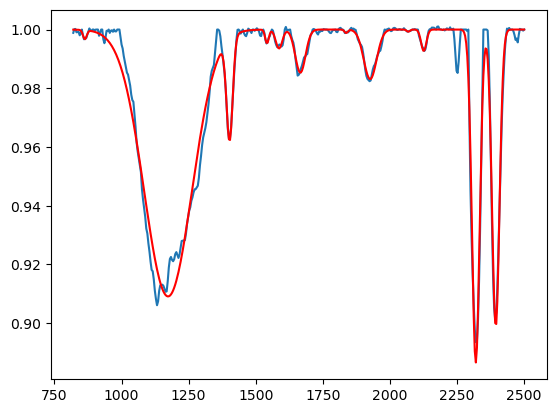

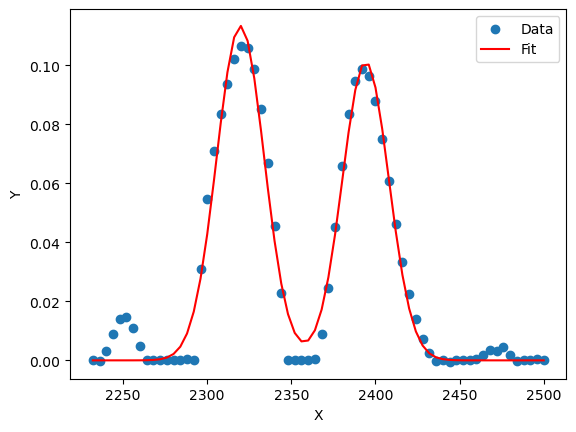

In [73]:
# Get the entire spectrum in the range where we care about the peaks

curr_start = min_list[hull_correct_bool].min()
curr_stop  = max_list[hull_correct_bool].max()

curr_mask = get_mask_from_waves(wav_array, curr_start, curr_stop)

curr_wavs = wav_array[curr_mask]
curr_peaks = 1 - curr_quotient[curr_mask]

fit_peaks = find_peaks(curr_peaks,
                       width = 4)[0]

plt.plot(curr_wavs, curr_peaks)
plt.plot(curr_wavs[fit_peaks], curr_peaks[fit_peaks], 'o')

def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y

guess = []
for p in fit_peaks:
    guess.append(np.round(curr_wavs[p]))
    guess.append(curr_peaks[p])
    guess.append(10)

popt, pcov = curve_fit(func,
                       curr_wavs,
                       curr_peaks,
                       p0=guess)
fit = func(curr_wavs, *popt)

plt.figure()
plt.plot(curr_wavs,
         1-curr_peaks)
plt.plot(curr_wavs,
         1-fit ,
         'r-')
plt.show()


i = 16
label_subset = pd.Series(mineral_label)[hull_correct_bool].to_list()

if hull_correct_bool[i]:
    curr_min =  min_list[i-2]
    curr_max =  max_list[i+3]
    
    curr_mask = get_mask_from_waves(curr_wavs, curr_min, curr_max)
    this_wavs = curr_wavs[curr_mask]
    this_peak = 1-curr_peaks[curr_mask]

    # Plot the original data and the fitted curve
    plt.figure()
    plt.scatter(this_wavs,
                1-this_peak,
                label='Data')
    plt.plot(this_wavs, fit[curr_mask], 'r-', label='Fit')
    # plt.plot(x_values[test_peaks], y_values[test_peaks], 'x', label='Identified Peaks')
    # plt.title(label_subset[i])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

['molybdenite',
 'REE',
 'pyroxene',
 'micas, clays',
 'jarosite',
 'alunite',
 'epidote',
 'sulphates',
 'all OH, zeo',
 'gypsum',
 'pyrophyllite',
 'Al-OH',
 'chlorite, biotite',
 'Al-fe smectites',
 'Fe-Mg smectites',
 'chlorite, biotite',
 'tourmaline',
 'amphiboles, biotite']